<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/eclipseFluidCharNeqSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Python packages read Eclipse file and import Python libraries

In [22]:
%%capture
!pip install neqsim
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/example2.txt
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#Read fluid from Eclipse 300 file

In [23]:
file1 = open('example2.txt', "r")
FileContent = file1.read()
print(FileContent)

﻿-- Dummy EOS for FluidMagic Test case
-- 
-- Copyright (C) 2022 Equinor 


-- Units
METRIC
-- Number of components:
NCOMPS
22 /
-- Equation of state
EOS
PR /
PRCORR


-- Reservoir temperature (C)
RTEMP
     90.00 /


-- Standard Conditions (C and bara)
STCOND
   15.00000    1.01325  /


-- Component names
CNAMES
N2
CO2
C1
C2
C3
iC4
C4
iC5
C5
C6
C7
C8
C9
C10-C12
C13-C14
C15-C17
C18-C21
C22-C28
C29-C36
C37-C45
C46-C58
C59-C80 /
-- Tc (K)
TCRIT
   126.200
   304.200
   190.600
   305.400
   369.800
   408.100
   425.200
   460.400
   469.600
   507.400
   548.083
   568.470
   592.686
   631.845
   680.299
   727.035
   774.284
   851.846
   943.373
  1038.592
  1152.236
  1317.304 /
-- Pc (Bar)
PCRIT
   33.9439
   73.7646
   46.0015
   48.8387
   42.4552
   36.4770
   37.9969
   33.8426
   33.7412
   29.6882
   29.4519
   27.6423
   25.5535
   22.7296
   20.0143
   18.1224
   16.7108
   15.1759
   14.0297
   13.2891
   12.7370
   12.2645 /
-- Omega
ACF
   0.04000
   0.22500
   0.00800
 

#Create NeqSim fluid from Eclipse file
Run TP flash at reservoir temperature and pressure

In [29]:
fluid1 = readEclipseFluid('example2.txt')

reservoirPressure = 100
fluid1.setPressure(reservoirPressure, 'bara')
reservoirTemperature = 90.0 # C
fluid1.setTemperature(reservoirTemperature, 'C')

satpres = bubp(fluid1)
TPflash(fluid1)


print('saturation pressure at 90C ', fluid1.getPressure('bara'), ' bara')

printFrame(fluid1)

saturation pressure at 90C  189.774834606021  bara
| 0                  | 1           | 2                | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-----------------|:----|:----|:----|:----------------|
|                    | total       | OIL              |     |     |     |                 |
| nitrogen           | 3.912E-3    | 3.912E-3         |     |     |     | [mole fraction] |
| CO2                | 3.01E-3     | 3.01E-3          |     |     |     | [mole fraction] |
| methane            | 4.03275E-1  | 4.03275E-1       |     |     |     | [mole fraction] |
| ethane             | 7.6341E-2   | 7.6341E-2        |     |     |     | [mole fraction] |
| propane            | 7.9752E-2   | 7.9752E-2        |     |     |     | [mole fraction] |
| i-butane           | 1.1938E-2   | 1.1938E-2        |     |     |     | [mole fraction] |
| n-butane           | 4.0929E-2   | 4.0929E-2        |     |     |     | [mole fraction] |
| i-pentane          | 1.3944

#Create well streams, fit to gas and oil rates from reservoir simulation, mix and separate

In [30]:
from neqsim.process import  mixer, heater, stream, separator, GORfitter

In [33]:
#from eclipse
gas_flow = 1.0 #MSm3/day
oil_flow = 2000.0 #m3/hr
water_flow = 1000.0 #m3/hr

# Creating Well 1
well1 = stream(fluid1.clone())
molar_composition_well1 = [
    0.003912, 0.003010, 0.303275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340
]
well1.getFluid().setMolarComposition(molar_composition_well1)
well1.run()

flowset =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", well1)
flowset.setGasFlowRate(gas_flow, "MSm3/day")
flowset.setOilFlowRate(oil_flow, "m3/hr")
flowset.run()

well1Fitted = flowset.getOutStream()

#Creating Well 2
gas_flow2 = 1.0 #MSm3/day
oil_flow2 = 1200.0 #m3/hr

well2 = stream(fluid1.clone())
molar_composition_well2 = [
    0.003912, 0.003010, 0.403275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340
]
well2.getFluid().setMolarComposition(molar_composition_well2)
well2.run()

flowset2 =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", well2)
flowset2.setGasFlowRate(gas_flow2, "MSm3/day")
flowset2.setOilFlowRate(oil_flow2, "m3/hr")
flowset2.run()
well2Fitted = flowset2.getOutStream()


#Mixing stream
wellmixer = mixer('well mixer')
wellmixer.addStream(well1Fitted)
wellmixer.addStream(well2Fitted)
wellmixer.run()

#Setting pressure and temperature of inlet separator
wellTP = heater(wellmixer.getOutStream())
wellTP.setOutTemperature(15.0, 'C')
wellTP.setOutPressure(1.01325, 'bara')
wellTP.run()

#creating a inlet separator
inletsep = separator(wellTP.getOutStream())
inletsep.run()



gasFlowRate = inletsep.getGasOutStream().getFlowRate('MSm3/day')
gasAFlowRate = inletsep.getGasOutStream().getFlowRate('m3/hr')
oilFlowRate = inletsep.getLiquidOutStream().getFlowRate('m3/hr')

print('gas flow rate from separator ', gasFlowRate, ' MSm3/hr')
print('gas flow rate from separator ', gasAFlowRate, ' Am3/hr')
print('oil flow rate from separator ', oilFlowRate, ' m3/hr')

print('GOR from surface ', gasAFlowRate/oilFlowRate)

gas flow rate from separator  2.005565985399021  MSm3/hr
gas flow rate from separator  82993.30210943309  Am3/hr
oil flow rate from separator  3199.1160056091517  m3/hr
GOR from surface  25.942573499653424


#Running a CME simulation for the reservoir fluid

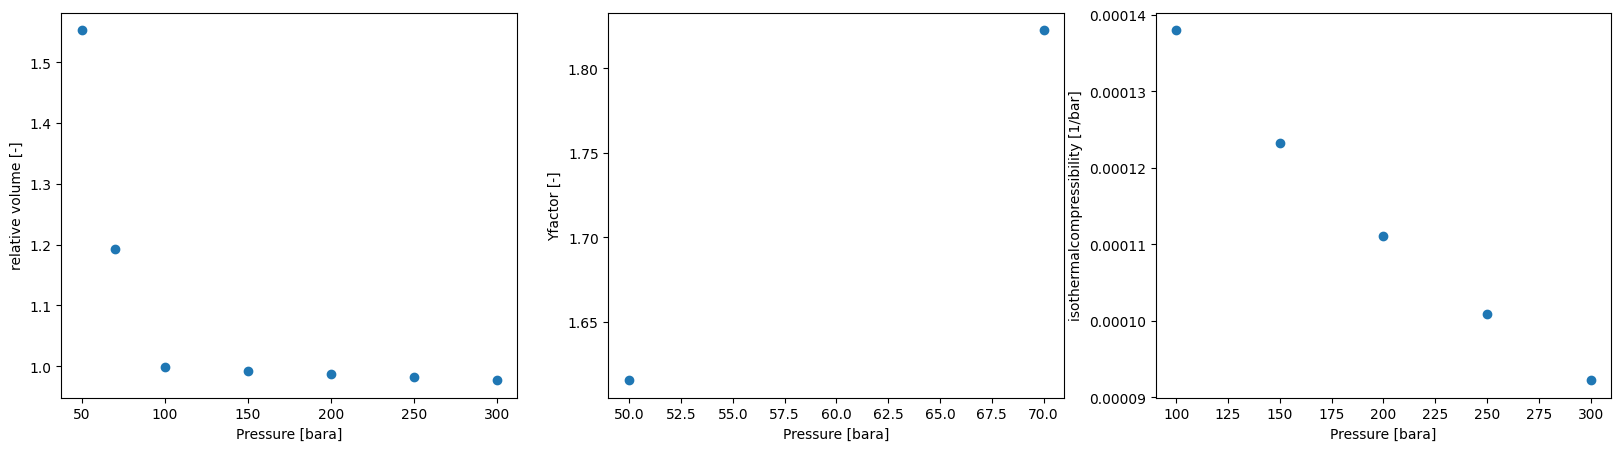

In [34]:
fluid1 = well1.getFluid().clone()

pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0]
temperature = [301.0, 301.0, 301.0, 301.0, 301.0, 301.0, 301.0]

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []
satPressure = None
CME(fluid1,pressure,temperature,satPressure,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()